# Vision Zero Data Dive

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
exp = pd.read_csv('OBJ1_streets_exposure.csv')

## Just use rows that have values for adt (average daily traffic)

In [4]:
df = exp[np.isfinite(exp['adt'])]
df.shape

(5066, 93)

## Filter out non-numerical data columns

In [5]:
#no objects, just numbers
noobj = df.select_dtypes(exclude=[object])
noobj.shape

(5066, 78)

In [6]:
data = noobj.ix[:, noobj.columns != 'adt']
data = data.fillna(value=0)  # fill in nans with zero

In [7]:
# all the data that is not object dtype
X_train = np.array(data)
X_train

array([[6, 1011, 100190, ..., 0.0, -122.341962263, 47.6106836074],
       [12, 1931, 4650220, ..., 0.0, -122.31469522299999, 47.5833419249],
       [26, 8730, 50450230, ..., 0.0, -122.350020753, 47.6121871535],
       ..., 
       [23756, 11876, 86650140, ..., 0.0, -122.32736021299999, 47.613438162],
       [23765, 9759, 60750620, ..., 0.0, -122.31228348299999,
        47.548061151000006],
       [23768, 1682, 3400600, ..., 0.0, -122.317314221, 47.548929465]], dtype=object)

In [8]:
Y_train = np.array(df['adt'])
Y_train

array([ 19396.,   8972.,  13492., ...,   1488.,   1165.,   1268.])

In [9]:
from sklearn import cross_validation
from sklearn.ensemble import RandomForestRegressor

In [10]:
model = RandomForestRegressor(n_estimators = 10)

## Baseline of R$^2$~80% for all numerical data
- non-finite values filled in with zeros
- no feature scaling

In [11]:
scores = cross_validation.cross_val_score(model, X_train, y=Y_train, cv=10, scoring='r2')
scores.mean()

0.80278120231620709

## Try log-transform of adt (Y_train)

In [12]:
Y_train_log = np.log(Y_train)
scores = cross_validation.cross_val_score(model, X_train, y=Y_train_log, cv=10, scoring='r2')
scores.mean()

0.82332148355650503

## Scale the training data

In [13]:
from sklearn import preprocessing

In [14]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)

/Users/jesford/anaconda/envs/py3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/jesford/anaconda/envs/py3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [15]:
scores = cross_validation.cross_val_score(model, X_train_transformed, 
                                          y=Y_train_log, cv=10, scoring='r2')
scores.mean()

0.81674273890906601

## Feature Importance

In [16]:
model.fit(X_train_transformed, y=Y_train_log)
importances = model.feature_importances_

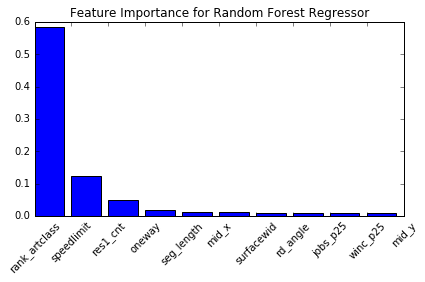

In [17]:
order = np.argsort(importances)[::-1]
order
plt.bar(range(X_train.shape[1]), importances[order])
plt.xticks(range(X_train.shape[1]), data.columns.values[order], rotation=45)
plt.xlim([0,10])
plt.title('Feature Importance for Random Forest Regressor')
plt.tight_layout()
plt.savefig('feature_importance.png')

In [18]:
data.head()

,Unnamed: 0,compkey,unitidsort,pvmtcondin,mjtrk_str,rank_artclass,surfacewid,oneway,tranclass,speedlimit,...,inds_cnt,res1_cnt,res2_cnt,vac_cnt,commu_cnt,inst_cnt,os_cnt,unkn_cnt,mid_x,mid_y
6,6,1011,100190,73,False,200,52,False,2,30,...,0,0,4,0,11,0,0,0,-122.341962,47.610684
12,12,1931,4650220,36,False,100,42,False,3,30,...,0,13,15,0,1,0,0,0,-122.314695,47.583342
26,26,8730,50450230,74,True,300,47,False,3,30,...,0,0,0,1,9,2,0,0,-122.350021,47.612187
28,28,19649,155900080,95,False,300,42,False,3,30,...,0,14,16,2,1,3,0,5,-122.321600,47.526461
32,32,18441,145400320,92,False,200,30,False,3,30,...,0,0,5,1,4,2,0,0,-122.398977,47.667471


## Output Predictions
Output a table of **unitidsort** and predicted **adt**

In [19]:
# data to predict adt for...
df2 = exp[np.isfinite(exp['adt']) == False]
noobj2 = df2.select_dtypes(exclude=[object])
data2 = noobj2.ix[:, noobj2.columns != 'adt']
data2 = data2.fillna(value=0)
X_predict = np.array(data2)

In [20]:
model.fit(X_train_transformed, y=Y_train_log)
log_adt_predicted = model.predict(X_predict)

In [21]:
adt_predicted = np.e**log_adt_predicted
adt_predicted

array([  6454.09910435,  11309.99147945,   5162.13997175, ...,
         3427.66971212,   6380.42978687,   6361.84893336])

In [22]:
output = pd.DataFrame({'unitidsort': np.array(data2['unitidsort']), 
                       'adt_predicted':adt_predicted})

In [23]:
output.head()

,adt_predicted,unitidsort
0,6454.099104,111550150
1,11309.991479,23750010
2,5162.139972,135200465
3,6185.074982,8450240
4,7336.139687,131450080


In [24]:
output.to_csv('prediction.csv', index=False)

## Try some different models...
- DecisionTreeRegressor
- Support Vector Regression 

In [25]:
from sklearn.tree import DecisionTreeRegressor

In [26]:
dtr1 = DecisionTreeRegressor(max_depth=2)
cross_validation.cross_val_score(dtr1, X_train_transformed, 
                                 y=Y_train_log, cv=10, scoring='r2').mean()

0.71044153912006047

In [27]:
dtr2 = DecisionTreeRegressor(max_depth=5)
cross_validation.cross_val_score(dtr2, X_train_transformed, 
                                 y=Y_train_log, cv=10, scoring='r2').mean()

0.78331855760526414

In [28]:
dtr3 = DecisionTreeRegressor(max_depth=10)
cross_validation.cross_val_score(dtr3, X_train_transformed, 
                                 y=Y_train_log, cv=10, scoring='r2').mean()

0.73691388845330796

In [29]:
from sklearn.svm import SVR

In [31]:
svr = SVR(kernel='rbf', C=1e3, gamma=0.1)
cross_validation.cross_val_score(svr, X_train_transformed, 
                                 y=Y_train_log, cv=10, scoring='r2').mean()

0.63699360486109868

### Result: Random Forest worked the best of these models